In [2]:
### INITIALIZATION

import pandas as pd
import numpy as np
from datetime import date
from openpyxl import load_workbook
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

In [3]:
### GENERAL DATA PREPARATION

### Constants:
All = slice(None)
### Universe path:
str_path_universe = 'Data_Files/Source_Files/acadian_universe.xlsx'
### Data source:
str_path_imf_export_source = 'Data_Files/Source_Files/IMF_Export_Data.xlsx'
str_path_imf_country_map = 'Data_Files/Source_Files/IMF_Country_Codes.xlsx'

In [ ]:
### DEFINING EXTRACTION UNIVERSE DATA FROM MS EXCEL SOURCE

def ison_membership_converting(str_path_universe, date_end, bool_daily = False, int_backfill_months = 0):
    ### Defining business-month-end reindexation on country level:
    def country_modify(ser_raw_country, date_end):
        ser_res_country = ser_raw_country.droplevel(0).resample('MS').last().resample('BM').last()
        range_country = pd.date_range(ser_res_country.index[0], date_end, freq = 'BM')
        return ser_res_country.reindex(range_country).ffill()
    ### Markets encoding table:
    dict_markets = {50 : 'DM', 57 : 'EM', 504 : 'FM', 0: np.NaN}     
    ### Loading source file:
    df_raw_universe = pd.read_excel(io = str_path_universe, sheet_name = 0, header = 0, parse_dates = True, index_col = [0, 1],
                                 na_values = ['', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', 
                                             '1.#QNAN', 'N/A', 'NULL', 'NaN', 'n/a', 'nan', 'null'], keep_default_na = False)
    ### Converting source file:
    df_raw_universe.index.names = ['Country', 'Date']
    ser_raw_universe = df_raw_universe['Region']
    ser_raw_universe.fillna(0, inplace = True)
    ser_raw_universe.name = 'Market'
    ### By country reindexation and translation:
    ser_res_universe = ser_raw_universe.groupby('Country').apply(country_modify, date_end)
    ser_res_universe.index.names = ['Country', 'Date']
    ser_res_universe = ser_res_universe.replace(dict_markets).reorder_levels([1, 0]).sort_index() 
    ### Expanding membership for primary regions members by backfilling:
    if int_backfill_months:
        ### List of regions:
        list_region = list(ser_res_universe.dropna().unique())
        ### Initialising of collection of series with backfilled data for each region:
        list_ison_backfill = []
        ### Regions looping:
        for iter_region in list_region:
            ### Defining start of region date:
            date_first_valid = ser_res_universe.loc[ser_res_universe == iter_region].first_valid_index()[0]
            ### Creating dates index to backfilling:
            idx_date_backfill = pd.date_range(end = date_first_valid, periods = int_backfill_months + 1, freq = 'BM')[: -1]
            ### Creating primary countries index to backfilling:            
            idx_region_backfill = ser_res_universe.loc[ser_res_universe == iter_region].loc[date_first_valid, All].index.get_level_values('Country')
            ### Creating full index:
            idx_ison_backfill = pd.MultiIndex.from_product([idx_date_backfill, idx_region_backfill])
            ### Series with backfilled data:
            list_ison_backfill.append(pd.Series(iter_region, index = idx_ison_backfill))
        ### Combination of backfilled series and original ISON data:    
        ser_res_universe = ser_res_universe.combine_first(pd.concat(list_ison_backfill, axis = 0)).sort_index()  
        ser_res_universe.index.names = ['Date', 'Country']
    ### Converting to daily frequency:
    if bool_daily:
        ser_res_universe = ser_res_universe.reset_index('Country').groupby('Country').resample('B').ffill()['Market'].swaplevel().sort_index()    
    ### Results output:
    ser_res_universe.name = 'Market'
    return ser_res_universe

In [ ]:
### DEFINING DATE/COUNTRY DATA VECTOR DESCRIBER FUNCTION

def date_country_vector_describer(ser_data, ser_ison):
    ### ISON countries set:
    set_ison_countries = set(ser_ison.index.get_level_values(1).unique())
    ### Vector countries set:    
    set_vector_countries = set(ser_data.dropna().index.get_level_values(1).unique())    
    ### Vector completeness:
    print('Data vector name: {}'.format(ser_data.name))
    print('Data vector completeness: {:.2%}'.format(ser_data.count() / len(ser_data.index))) 
    print('ISON countries completeness: {:.2%} ({} / {})'.format(len(set_vector_countries.intersection(set_ison_countries)) / len(set_ison_countries),
                                                                 len(set_vector_countries.intersection(set_ison_countries)),
                                                                 len(set_ison_countries)))
    print('Absent ISON countries: [{}]'.format(str(', '.join(sorted(list(set_ison_countries - set_vector_countries))))))
    ### ISON Universe binding (if needed):
    if not ('Market' in ser_data.index.names):
        ser_data = ser_data.to_frame().join(ser_ison, how = 'left').set_index('Market', append = True).squeeze()\
                                      .loc[All, All, ['DM', 'EM', 'FM']].sort_index(level = ['Date', 'Country'])
    ### Dates for heatmap x-axis labeles:
    list_idx_dates = ser_data.index.get_level_values('Date').unique()
    ### Dates reindexation (adding NaN values for absent observations):
    ser_region_data = ser_data.loc[All, All, ['DM', 'EM', 'FM']].droplevel('Market').unstack('Country').reindex(list_idx_dates).stack('Country', dropna = False)      
    ### Countries number for heatmap height defining:
    int_fig_height = len(ser_region_data.index.get_level_values('Country').unique())    
    ### Adding shade column for future heatmap striping:
    list_countries = list(ser_region_data.index.get_level_values('Country').unique())
    dict_countries = dict(zip(list_countries, map(lambda iter_num: iter_num % 2 + 2, range(len(list_countries)))))
    df_region_shades = ser_region_data.to_frame().assign(Shade = list(map(dict_countries.get, ser_region_data.index.get_level_values('Country'))))
    df_region_shades.columns = ['Data', 'Shade']
    ### Heatmap drawing:
    fig_heatmap = plt.figure(figsize = (15, int_fig_height // 5))
    df_region_data = (df_region_shades['Data'] / df_region_shades['Data'] * df_region_shades['Shade']).unstack('Date').sort_index()
    df_region_data.columns = df_region_data.columns.strftime('%d-%m-%Y')
    ax_heatmap = sns.heatmap(df_region_data, cbar = False, annot = False, cmap = 'binary', xticklabels = 'auto', yticklabels = True, 
                             vmin = 0.0, vmax = 6.0)
    ax_heatmap.set_title('ISON Universe')    
    ### Visualizer heatmap plotting:        
    for str_region_code, ser_region_data in ser_data.groupby('Market'):
        ### Dates reindexation (adding NaN values for absent observations):
        ser_region_data = ser_region_data.droplevel('Market').unstack('Country').reindex(list_idx_dates).stack('Country', dropna = False)   
        ### Countries number for heatmap height defining:        
        int_fig_height = len(ser_region_data.index.get_level_values('Country').unique())
        if (int_fig_height > 5):
            ### Adding shade column for future heatmap striping:
            list_countries = list(ser_region_data.index.get_level_values('Country').unique())
            dict_countries = dict(zip(list_countries, map(lambda iter_num: iter_num % 2 + 2, range(len(list_countries)))))
            df_region_shades = ser_region_data.to_frame().assign(Shade = list(map(dict_countries.get, ser_region_data.index.get_level_values('Country'))))
            df_region_shades.columns = ['Data', 'Shade']
            ### Heatmap drawing:
            fig_heatmap = plt.figure(figsize = (15, int_fig_height // 5))
            df_region_data = (df_region_shades['Data'] / df_region_shades['Data'] * df_region_shades['Shade']).unstack('Date').sort_index()
            df_region_data.columns = df_region_data.columns.strftime('%d-%m-%Y')
            ax_heatmap = sns.heatmap(df_region_data, cbar = False, annot = False, cmap = 'binary', xticklabels = 'auto', yticklabels = True, 
                                     vmin = 0.0, vmax = 6.0)
            ax_heatmap.set_title(str_region_code)
        else:
            print('Too few countries to show heatmap for', str_region_code, '(', int_fig_height, ')')
    ### Plots showing:
    plt.show()

In [62]:
### TEMP

### ISON loading:
ser_ison = ison_membership_converting(str_path_universe, date_end)
### ISON countries extracting:
list_ison_countries = list(ser_ison.index.levels[1].unique())
### Loading raw excel IMF country map:
df_imf_full_map = pd.read_excel(io = str_path_imf_country_map, sheet_name = 0, header = 0, usecols = [1, 2, 5], index_col = 1, 
                                na_values = ['', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', '#N/A Requesting Data...',
                                             '1.#QNAN', 'N/A', 'NULL', 'NaN', 'n/a', 'nan', 'null', '#N/A Invalid Security'], keep_default_na = False)
### IMF country map regulation: 
df_imf_full_map.index.names = ['ISO Code']
df_imf_full_map.columns = ['Name', 'IMF Code']
df_imf_full_map['IMF Code'] = df_imf_full_map['IMF Code'].replace({'NA': np.NaN})
### Filtering IMF Country map for ISON countries only:
df_imf_ison_map = df_imf_full_map.loc[list_ison_countries, All]
df_imf_ison_map['IMF Code'] = df_imf_ison_map['IMF Code'].astype(int)
### Making a translation dictionary:
dict_code_translation = dict(zip(df_imf_ison_map['IMF Code'], df_imf_ison_map.index))
### Loading raw excel source with Ezport data:
dict_imf_export_data = pd.read_excel(io = str_path_imf_export_source, sheet_name = None, header = 0, usecols = [1, 4, 5], index_col = None, 
                              na_values = ['', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', '#N/A Requesting Data...',
                                           '1.#QNAN', 'N/A', 'NULL', 'NaN', 'n/a', 'nan', 'null', '#N/A Invalid Security'], keep_default_na = False)
### Divding data types and combining data inside the type:
dict_imf_epi_data = {}
dict_imf_gdp_data = {}
dict_imf_export_types = {}
for iter_key in dict_imf_export_data.keys():
    if iter_key.find('Index') > -1:
        dict_imf_epi_data[iter_key] = dict_imf_export_data[iter_key]
    else:
        dict_imf_gdp_data[iter_key] = dict_imf_export_data[iter_key]       
dict_imf_export_types['EPI'] = pd.concat(dict_imf_epi_data)
dict_imf_export_types['GDP'] = pd.concat(dict_imf_gdp_data)
dict_imf_export_ser = {}
for iter_type in dict_imf_export_types:
    df_imf_export_type = dict_imf_export_types[iter_type].sort_index()
    df_imf_export_type.index.names = ['Type', 'Default']
    df_imf_export_type.reset_index('Type', inplace = True)
    df_imf_export_type['Code'] = df_imf_export_type['Country Code'].replace(dict_code_translation)
    df_imf_export_type['Frequency'] = df_imf_export_type['Type'].str[-1]
    df_imf_export_type.set_index(['Frequency', 'Code'], inplace = True, append = True)
    df_imf_export_type['Date'] = np.NaN
    if ('Y' in df_imf_export_type.index.levels[1].unique()):    
        df_imf_export_type.loc[(All, 'Y', All), 'Date'] = pd.to_datetime(df_imf_export_type.loc[(All, 'Y', All), 'Time Period'].astype(str) + '1201')\
                                                        + 0 * pd.tseries.offsets.BMonthEnd()
    if ('Q' in df_imf_export_type.index.levels[1].unique()):
        df_imf_export_type.loc[(All, 'Q', All), 'Date'] = pd.to_datetime(df_imf_export_type.loc[(All, 'Q', All), 'Time Period']) + 0 * pd.tseries.offsets.BQuarterEnd()
    if ('M' in df_imf_export_type.index.levels[1].unique()):
        df_imf_export_type.loc[(All, 'M', All), 'Time Period'] = df_imf_export_type.loc[(All, 'M', All), 'Time Period']\
                                                                    .str.replace('M', '-0').str.replace('-010', '-10').str.replace('-011', '-11').str.replace('-012', '-12')
        df_imf_export_type.loc[(All, 'M', All), 'Date'] = pd.to_datetime(df_imf_export_type.loc[(All, 'M', All), 'Time Period']) + 0 * pd.tseries.offsets.BMonthEnd()
    df_imf_export_type['Date'] = pd.to_datetime(df_imf_export_type['Date'])
    dict_imf_export_ser[iter_type] = df_imf_export_type.reset_index().set_index(['Frequency', 'Date', 'Code'])['Value']
    dict_imf_export_ser[iter_type].index.set_names('Country', level = 'Code', inplace = True)
    dict_imf_export_ser[iter_type] = dict_imf_export_ser[iter_type].loc[All, All, df_imf_ison_map.index]

Data vector name: EPI: M
Data vector completeness: 100.00%
ISON countries completeness: 27.38% (23 / 84)
Absent ISON countries: [AE, AR, AT, BD, BE, BG, BH, BW, CA, CH, CI, CL, CN, CR, CY, DK, EC, EG, ES, GH, HK, HR, HU, IL, IN, IT, JO, KE, KW, KZ, LB, LV, MA, MT, MU, MY, NA, NG, NL, NO, NZ, OM, PA, PE, PK, PL, PT, QA, RO, RS, RU, SA, SK, TH, TN, TR, TW, UA, UG, VN, ZM]
Too few countries to show heatmap for FM ( 3 )


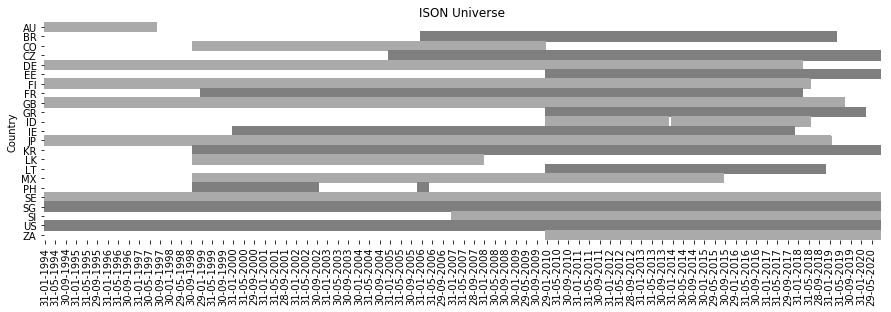

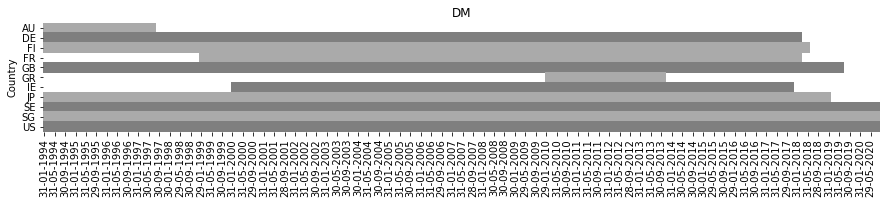

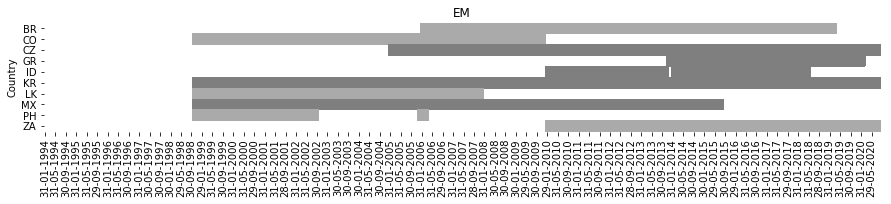

Data vector name: EPI: Q
Data vector completeness: 100.00%
ISON countries completeness: 34.52% (29 / 84)
Absent ISON countries: [AE, AR, BD, BE, BG, BH, BW, CA, CH, CI, CL, CN, CR, CY, DK, EC, EG, ES, GH, HK, HR, IL, IN, IT, JO, KE, KW, KZ, LB, LV, MA, MT, MY, NA, NG, NL, NO, OM, PA, PE, PK, QA, RO, RS, RU, SA, SK, TH, TN, TR, TW, UA, UG, VN, ZM]
Too few countries to show heatmap for FM ( 4 )


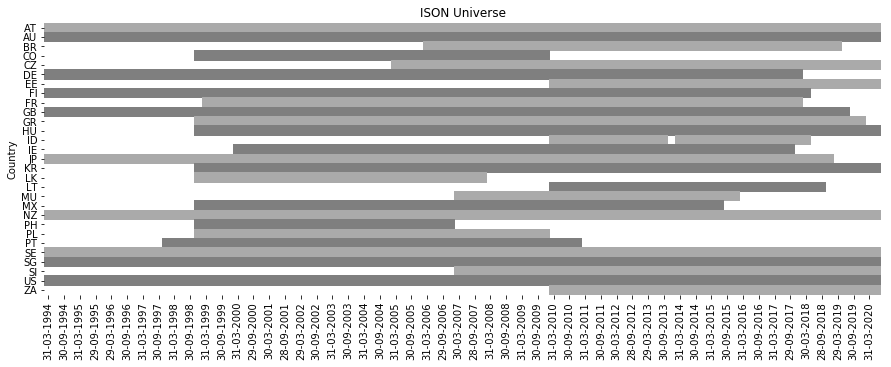

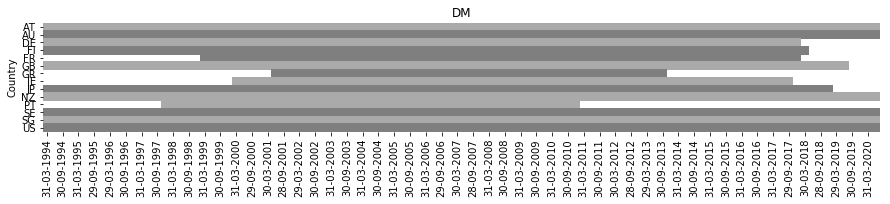

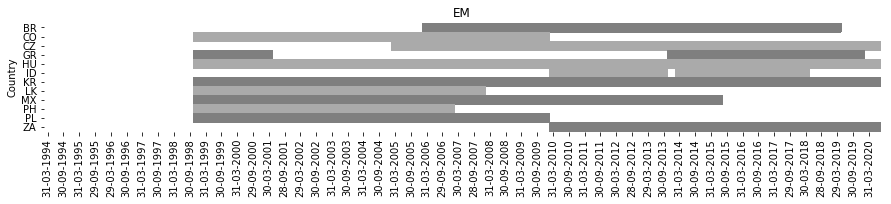

Data vector name: EPI: Y
Data vector completeness: 100.00%
ISON countries completeness: 36.90% (31 / 84)
Absent ISON countries: [AE, AR, BD, BE, BG, BH, BW, CH, CI, CL, CN, CR, CY, DK, EC, EG, ES, GH, HK, HR, IL, IN, IT, JO, KE, KW, KZ, LB, LV, MA, MT, MY, NA, NG, NL, NO, OM, PA, PE, PK, QA, RO, RS, RU, SA, SK, TH, TN, TR, TW, UA, UG, VN]
Too few countries to show heatmap for FM ( 4 )


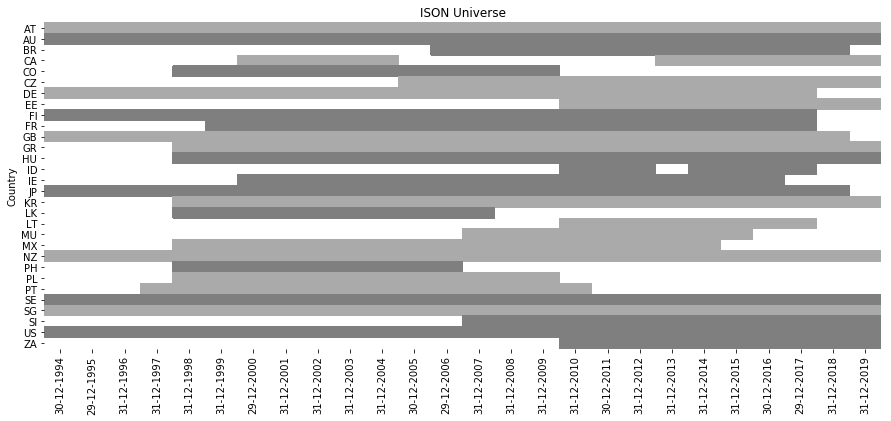

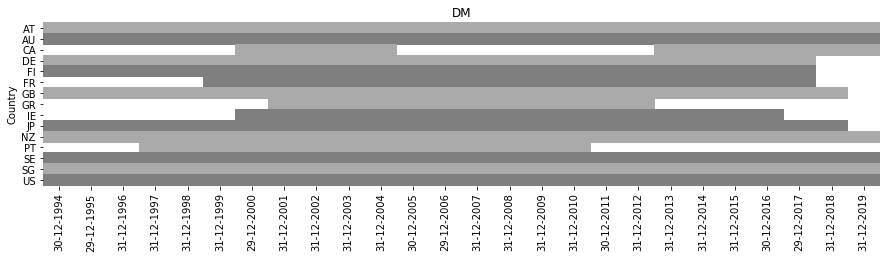

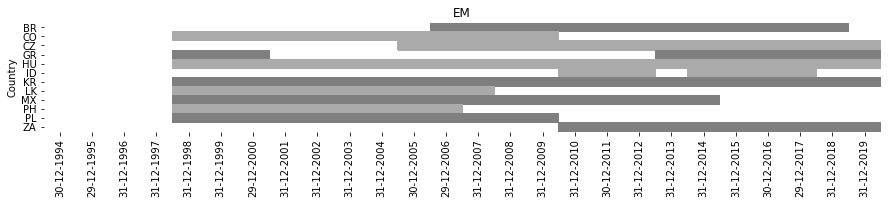

Data vector name: GDP: Q
Data vector completeness: 100.00%
ISON countries completeness: 57.14% (48 / 84)
Absent ISON countries: [AE, BD, BH, BW, CI, CN, EG, GH, HK, JO, KE, KW, KZ, LB, LK, MA, MU, MY, NA, NG, OM, PA, PE, PH, PK, QA, SA, SG, SK, TN, TR, TW, UA, UG, VN, ZM]


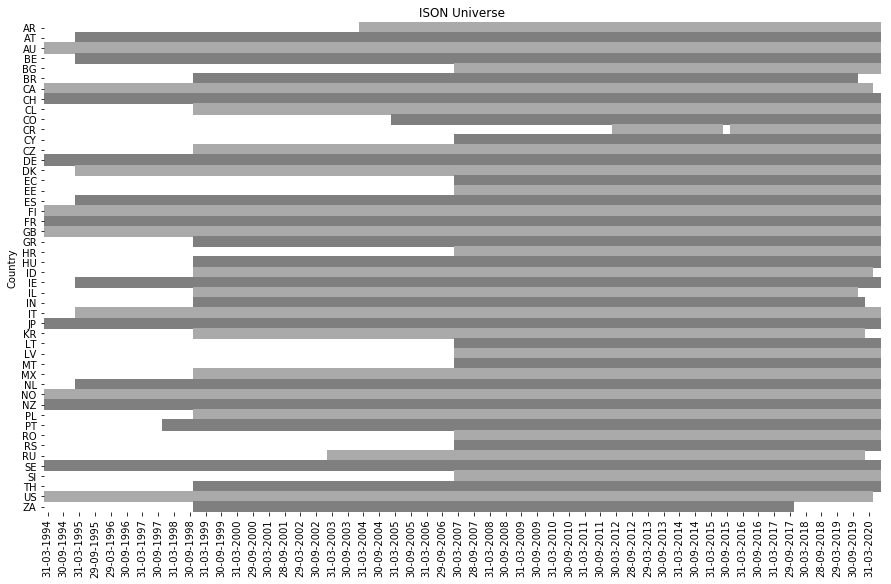

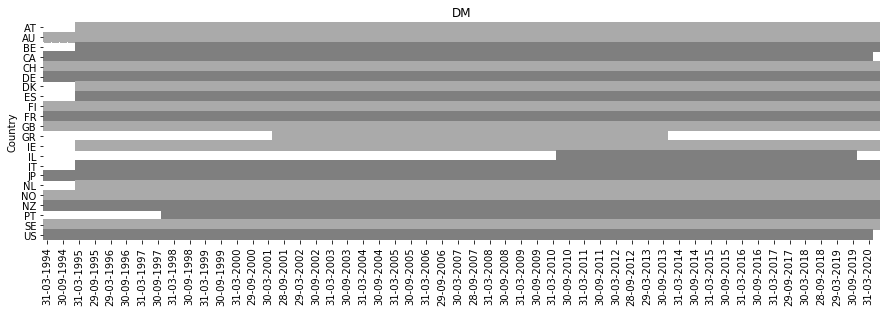

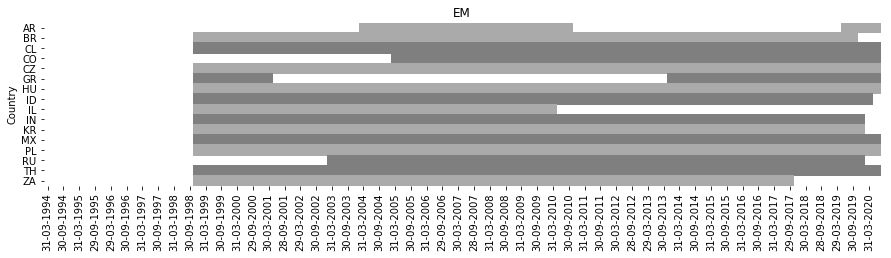

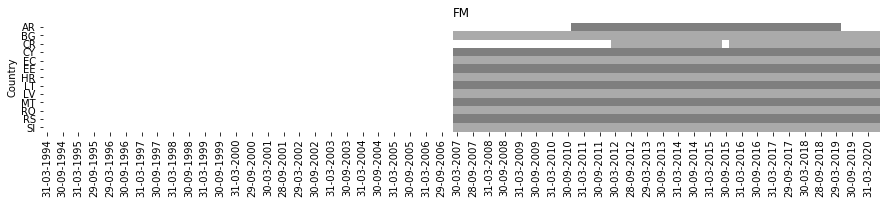

Data vector name: GDP: Y
Data vector completeness: 100.00%
ISON countries completeness: 65.48% (55 / 84)
Absent ISON countries: [AE, BD, BH, BW, CI, CN, EG, GH, HK, JO, KE, KW, KZ, LB, MA, MU, MY, NA, NG, OM, PH, PK, SA, TN, TW, UA, UG, VN, ZM]


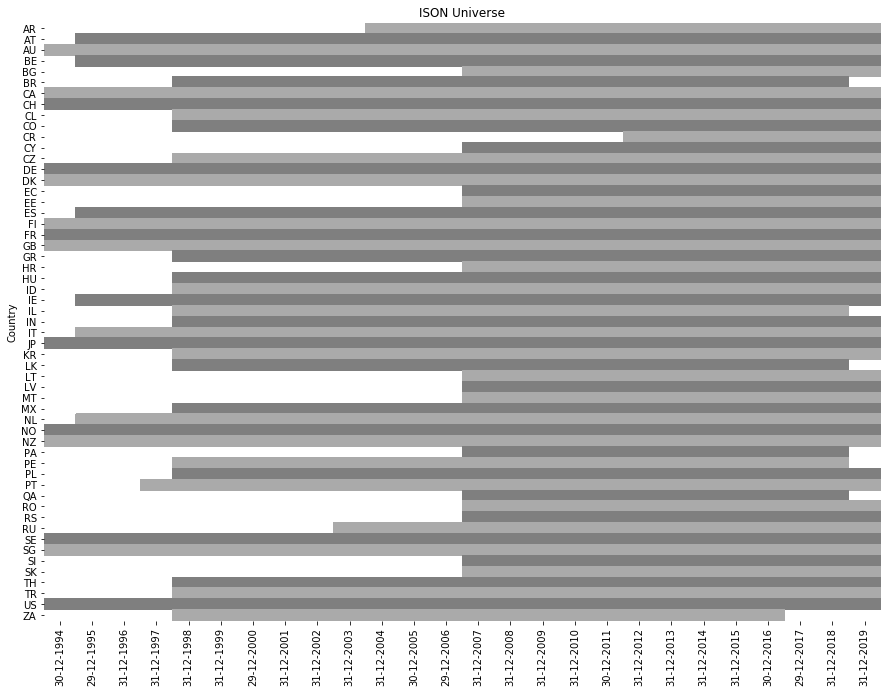

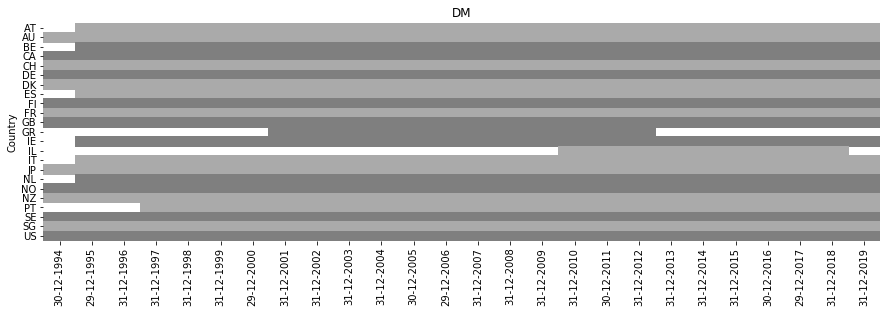

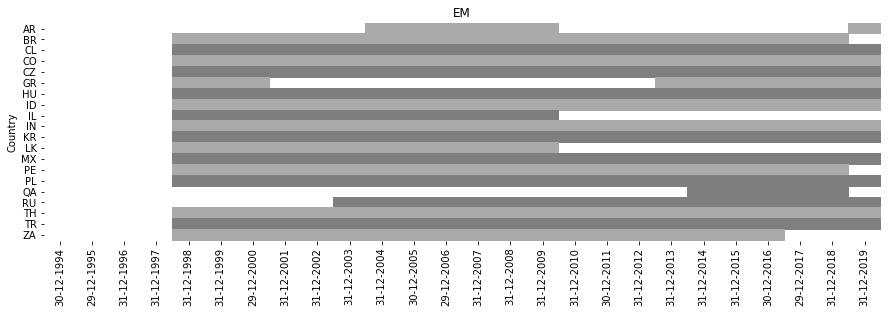

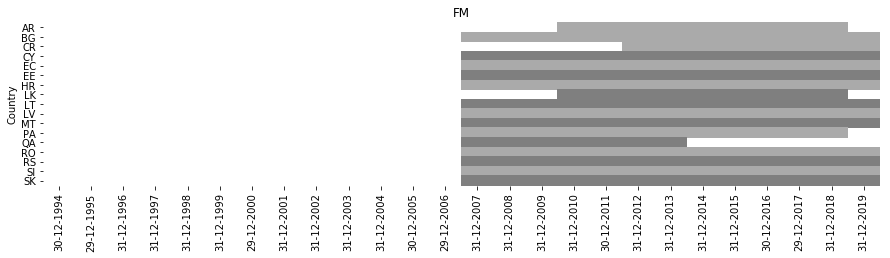

In [143]:
### TEMP

for iter_type in dict_imf_export_ser:
    ser_imf_export = dict_imf_export_ser[iter_type]
    for iter_freq in ['M', 'Q', 'Y']:
        if iter_freq in ser_imf_export.index.levels[0]:
            ser_freq = ser_imf_export.loc[iter_freq, All, All].droplevel(0)
            ser_freq.name = iter_type + ': ' + iter_freq
            date_country_vector_describer(ser_freq, ser_ison)